In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define input shape
input_shape = (28, 28, 1)

# Define input layer
inputs = Input(shape=input_shape)

# Define parallel branches
branch1 = Conv2D(filters=32, kernel_size=3, dilation_rate=1, padding='same', activation='relu')(inputs)
branch2 = Conv2D(filters=32, kernel_size=3, dilation_rate=2, padding='same', activation='relu')(inputs)
branch3 = Conv2D(filters=32, kernel_size=3, dilation_rate=4, padding='same', activation='relu')(inputs)

# Concatenate the parallel branches
concat = Concatenate()([branch1, branch2, branch3])

# Flatten the concatenated features
flatten = Flatten()(concat)

# Add a dense layer for classification
outputs = Dense(units=10, activation='softmax')(flatten)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)


Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1315 - accuracy: 0.9603 - val_loss: 0.0607 - val_accuracy: 0.9830
Epoch 2/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0474 - accuracy: 0.9857 - val_loss: 0.0550 - val_accuracy: 0.9824
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 0.0487 - val_accuracy: 0.9846
Epoch 4/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0508 - val_accuracy: 0.9845
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0555 - val_accuracy: 0.9838
Epoch 6/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0720 - val_accuracy: 0.9814
Epoch 7/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0647 -

In [2]:
import numpy as np

num_images = 5
random_indices = np.random.randint(0, len(X_test), num_images)
images = X_test[random_indices]
labels = y_test[random_indices]

In [3]:
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 69ms/step


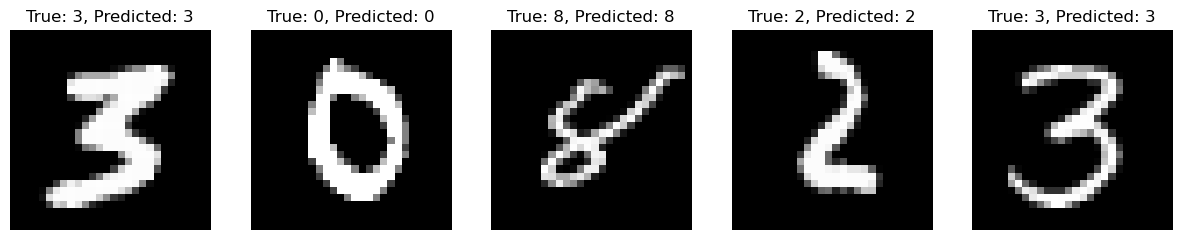

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {np.argmax(labels[i])}, Predicted: {predicted_labels[i]}')
    axes[i].axis('off')

plt.show()

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                              

In [6]:
model.save("model4.h5")

In [7]:
from keras import applications
import onnx
from tensorflow.python.keras.models import load_model

In [8]:
import tensorflow as tf
model = tf.keras.models.load_model("model4.h5")
tf.saved_model.save(model, "tmp_model")

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


In [9]:
!python -m tf2onnx.convert --saved-model tmp_model --output "model4.onnx"

C:\Users\prabh\anaconda3\lib\runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-06-25 13:51:21,781 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-06-25 13:51:22,013 - INFO - Signatures found in model: [serving_default].
2023-06-25 13:51:22,013 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-06-25 13:51:22,013 - INFO - Output names: ['dense']
2023-06-25 13:51:22,146 - INFO - Using tensorflow=2.12.0, onnx=1.13.1, tf2onnx=1.13.0/2c1db5
2023-06-25 13:51:22,146 - INFO - Using opset <onnx, 13>
2023-06-25 13:51:22,172 - INFO - Computed 0 values for constant folding
2023-06-25 13:51:22,201 - INFO - Optimizing ONNX model
2023-06-25 13:51:22,283 - INFO - After optimization: Cast -1 (1->0), Identity -2 (2->0), Reshape +1 (1->2), Transpose -5 (6->1)
2023-06-25

In [10]:
import netron

In [11]:
netron.start("model4.onnx")

Serving 'model4.onnx' at http://localhost:8080


('localhost', 8080)